# Presentation : Conformal prediction implementation in River

- BOGGIO Richard
- MDIHI Samy
- VERON Marc

This notebook is a presentation of the possibilities offered by the implementation of Conformal Prediction in the River framework. We rely on the paper by Margaux Zaffran et al. "Adaptative Conformal Predictions for Time series" (https://arxiv.org/abs/2202.07282). This paper has 2 parts: expert aggregation for regression or classification, and the definition of confidence intervals on streaming data. We focus here on the implementation in River of these confidence interval estimation techniques. We rely on the work of the research group, visible on github : https://github.com/mzaffran/AdaptiveConformalPredictionsTimeSeries

Quick Vocabulary: Conformal prediction is a general term for identifying confidence interval definition methods in machine learning that go beyond the simple gaussian approach. 



So we first increased the conf module. This one is present on the River git repo, but is not deployed on the downloadable version of Python. These are the parent classes of the interval methods that can be used in different regression models. Next, we augment the time_series module, in which we update the evaluation method to allow for intervals at different horizons. Indeed the logic of this module is to predict not only at horizon 1, but further. The calculation of intervals must therefore be integrated into this logic, hence the basic definition in conf. 

To ensure the integration of all these methods, we have updated the **\_\_init\_\_** files and the **base** files. This allows us to have an almost functional environment. 

## Modules imports

The modules that have been modified in River are the below : 
- In **conf** : base.py contains the Interval class, the mother for the interval methods (gaussian, CP, ACP)
- **time_series** : Intervals is the mother class that allows to apply the interval method at every horizon. To do so we replicated the metrics.py template. Also contains evaluates, hoeffding_horizon

In [1]:
# Existing in River
from river import datasets, metrics, stream
from river import tree, utils
from river import optim
from river import stats 
from river import preprocessing

# Not existing in River
import conf.ACP
import conf.CP
import conf.gaussian
import time_series
import time_series.evaluates
from time_series.holt_winters import HoltWinters
from time_series.hoeffding_horizon import HoeffdingTreeHorizon
from time_series.evaluates import _iter_with_horizon

# Other 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import timeit
import time
from scipy.stats import norm
from ipywidgets import widgets, interact

In [2]:
dir(conf)

['ACP',
 'AdaptativeConformalPrediction',
 'CP',
 'ConformalPrediction',
 'Gaussian',
 'Interval',
 'RegressionJackknife',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'base',
 'gaussian',
 'jackknife']

In [3]:
dir(time_series)

['ForecastingInterval',
 'ForecastingMetric',
 'HoeffdingTreeHorizon',
 'HoltWinters',
 'HorizonAggMetric',
 'HorizonInterval',
 'HorizonMetric',
 'SNARIMAX',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_iter_with_horizon',
 'base',
 'evaluate',
 'evaluates',
 'get_iter_evaluate',
 'hoeffding_horizon',
 'holt_winters',
 'intervals',
 'iter_evaluate',
 'metrics',
 'snarimax']

## Quantile estimation

The definition of confidence intervals lies mainly in the estimation of quantiles of the distribution of empirical data. Streaming data prevents the use of classical modules, notably numpy, whose approach is batch. Here we want to perform the calculations on a rolling window, relying only on the tools offered by river. We therefore check the validity of the results of the estimation of the quantiles of a normal distribution with river (stats module) compared to Numpy (norm module).

In [4]:
# Get a normal distribution
normal_dist = optim.initializers.Normal(mu=0, sigma=1, seed=42)
big_dist = normal_dist(shape=500000)

# confidence level
alpha = 0.975
# Compute with river
rolling_quantile = stats.Quantile(alpha)
for x in big_dist:
    _ = rolling_quantile.update(x)

# Check equivalence
print(f"with Scipy : {norm.ppf(alpha):.3f}")
print(f"with River : {rolling_quantile.get():.3f}")

with Scipy : 1.960
with River : 1.960


## Airline passengers prediction

We first present the use of the methods presented above in the HoltWinters model on Airline passengers data. This allows us to see how the intervals work, which is similar to that of the metrics. 

In [5]:
dataset = datasets.AirlinePassengers()

**Defining the forecasting model**

In [6]:
model = HoltWinters(
        alpha=0.3,
        beta=0.1,
        gamma=0.6,
        seasonality=12,
        multiplicative=True
        )

**Defining the metric and interval method**

In [7]:
calib_period = 100
metric = metrics.MAE()
interval = conf.gaussian.Gaussian(window_size=calib_period, alpha=0.10)

**Evaluation of the model**

In [8]:
time_series.evaluate(
        dataset,
        model,
        metric,
        interval,
        horizon=12,
        residual_calibration_period = calib_period
        )


(+1  MAE: 39.432543
 +2  MAE: 38.132746
 +3  MAE: 37.370918
 +4  MAE: 37.74146
 +5  MAE: 37.968714
 +6  MAE: 38.922898
 +7  MAE: 42.079442
 +8  MAE: 42.828249
 +9  MAE: 47.111859
 +10 MAE: 48.481283
 +11 MAE: 50.429104
 +12 MAE: 50.401671,
 +1  (400.3895748950096, 377.02385366644893)
 +2  (424.8694745643036, 396.90350188804223)
 +3  (405.2395450495128, 373.13925424292086)
 +4  (472.8584163332991, 441.92991528302394)
 +5  (458.15125908544024, 431.65673049325636)
 +6  (480.0768254499125, 457.0372778746278)
 +7  (549.0050911151861, 527.8836609308194)
 +8  (633.8011412623661, 610.7329624711675)
 +9  (644.4401685271714, 620.8860214364877)
 +10 (531.3026391346808, 508.6725961298399)
 +11 (468.75223087639944, 442.7874125602688)
 +12 (413.0926153477715, 387.632074564122))

The method get_iter_evaluate presents the integration of the intervals in the library. In fact it returns, in addition to the list of metrics, the list of intervals. 

In [9]:
list_x, list_y, list_y_pred, list_metrics, list_interval = time_series.get_iter_evaluate(
        dataset,
        model,
        metric,
        interval,
        horizon=12,
        residual_calibration_period = calib_period
        )

In [ ]:
list_interval

### Training a model with conformal predictions

Below is the **training method of a prediction model with confidence intervals**. In addition to the pre-training part of the model and the prediction part, it is necessary to add a pre-definition part of the intervals. This one is based on the residuals coming from the first part of the pre-train. Once this one is done, we come back to the beginning of the dataset to compute the resulting residuals. This allows us to have a first estimate of the quantiles on enough data. 

In [11]:
def run (model: time_series.base.Forecaster,
         stream_dataset, 
         metric=metrics.MAE(), 
         interval=conf.gaussian.Gaussian(window_size=1000, alpha=0.10),
         horizon=1,
         step=1, 
         verbose=True,
         plot=[]
        ):
    """Run the model on the dataset, and return the prediction with interval

    Parameters
    ----------
    model : tree.HoeffdingAdaptiveTreeRegressor
        the tree model
    dataset : _type_
        _description_
    cache_key : _type_
        _description_
    step : int, optional
        _description_, by default 1
    verbose : bool, optional
        _description_, by default True

    Returns
    -------
    _type_
        _description_
    """
    start = time.time()   

    # Defining the metric for the horizon
    horizon_metric = time_series.HorizonMetric(metric)
    # Defining the interval for a certain horizon
    horizon_interval = time_series.HorizonInterval(interval)
    
    # Defining the receiving list to output
    list_y = []
    list_yh = []
    list_ypred = []
    list_metric = []
    list_interval = []
    i = 0

    ##############################################################################
    # Pre-train the model
    ##############################################################################

    # Initialize the dataset from the beginning to get the grace period
    steps = _iter_with_horizon(stream_dataset, horizon)

    # Pre train the model on a defined quantities of sample "grace_periode"
    # Set the grace period as the max between horizon and the interval.window_size
    grace_period = max(horizon, interval.window_size)

    # Go over the grace_period to fit the model
    for t in range(grace_period):
        x, y, x_horizon, y_horizon = next(steps)
        model.learn_one(y=y, x=x)  # type: ignore
        if t >= interval.window_size:
            break


    ##############################################################################
    # Get first residuals series with the pre-trained model
    ##############################################################################

    # Reinitialize the dataset from the beginning to get the grace period
    # And initialize the interval window
    # TODO : being able to predict_many. Would be easier
    steps = _iter_with_horizon(stream_dataset, horizon)
    for _ in range(grace_period):
        x, y, x_horizon, y_horizon = next(steps)
        # Get the residual that will be used for calibration
        # calibration predictions (subset of training points)
        y_pred = model.forecast(horizon, xs=x_horizon)
        # Initializing the interval for each horizon
        horizon_interval.update(y_horizon, y_pred)


    ##############################################################################
    # Forecast with intervals and learn
    ##############################################################################

    # No reinitialisation of the dataset since we begin from where we stopped 
    # at the pre-train stage
    i=0
    for x, y, x_horizon, y_horizon in steps:
        # Predicting future values until a certain horizon
        y_pred = model.forecast(horizon, xs=x_horizon)
        # Updating the metric
        horizon_metric.update(y_horizon, y_pred)
        # Updating the interval for each horizon
        horizon_interval.update(y_horizon, y_pred)
        # Train the model
        model.learn_one(y=y, x=x)  # type: ignore



        # Incremente the list of metric values
        if (i+1)%step==0:
            list_metric.append(horizon_metric.get())
            list_interval.append(horizon_interval.get())
            list_y.append(y)
            list_yh.append(y_horizon)
            list_ypred.append(y_pred)

            if verbose:
                print(f"{i+1} samples : full = {list_metric[-1][0]:0.2f}")
        i += 1
    end = time.time()
    if verbose:
        print(f"\nStream passed in {end-start:.2f} seconds")


    return list_y, list_yh, list_ypred, list_metric, list_interval

**Plot interval**

In [12]:
def plot_interval(list_interval, list_y, range_toPlot):
    
    # Transform in array
    arr_interval = np.asarray(list_interval)
    arr_y = np.asarray(list_y)

    begin_at, end_at = range_toPlot

    fig, ax = plt.subplots()
    ax.plot(arr_y[begin_at:end_at], label="Water flow")
    ax.fill_between(np.arange(end_at-begin_at), 
                    arr_interval[begin_at:end_at].squeeze(1)[:,0], 
                    arr_interval[begin_at:end_at].squeeze(1)[:,1], 
                    color='b', alpha=.1)
    if range_toPlot[0] > 0:
        ax.set_title((f"{interval.__class__.__name__} interval at "
                        f"{interval.alpha*100:.0f}% for {model.__class__.__name__} "
                        f"on {dataset.__class__.__name__}. ZOOM = {range_toPlot}"
                        ))

    else:
        ax.set_title((f"{interval.__class__.__name__} interval at "
                        f"{interval.alpha*100:.0f}% for {model.__class__.__name__} "
                        f"on {dataset.__class__.__name__}"
                        ))
    fig.tight_layout()
    ax.plot()
    

# 1st method : Gaussian Interval

**HoltWinters on bigger dataset : WaterFlow**

In [ ]:
dataset = datasets.WaterFlow()

model = HoltWinters(
        alpha=0.8,
        beta=0.1,
        gamma=0.6,
        seasonality=2,
        multiplicative=True
        )

metric = metrics.MSE()

calib_period = 100
alpha=0.05
interval = conf.gaussian.Gaussian(window_size=calib_period, alpha=alpha)

# Run and get all the relevant lists
plot_zoom = [180,700]
plot_full = [0,1166]
list_y, _, _, list_metric, list_interval = run(model, dataset, metric, interval, horizon=1)

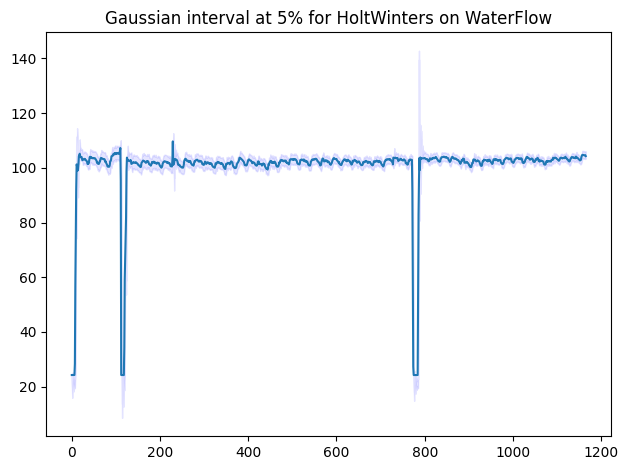

In [14]:
_ = plot_interval(list_interval,list_y,plot_full)

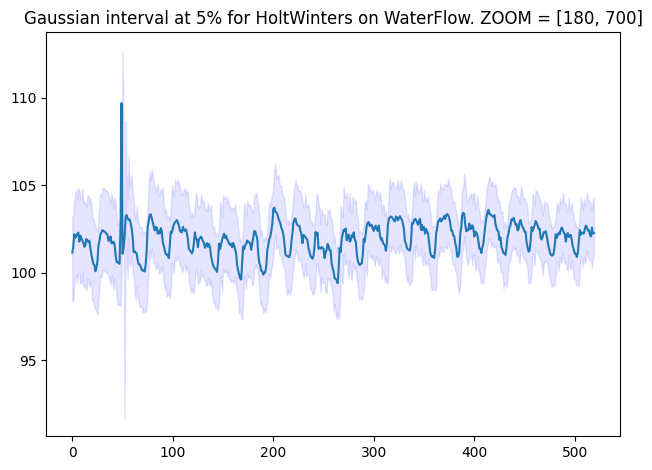

In [15]:
plot_interval(list_interval,list_y,plot_zoom)

We see that the interval with Gaussian method is regular around the residuals, and does not take into account the improvement of the model (the reduction of the std of the residuals).

[]

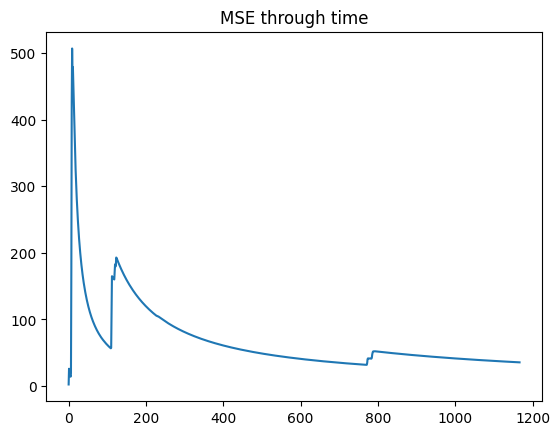

In [16]:
arr_metrics = np.asarray(list_metric)
plt.plot(arr_metrics[:,0])
plt.title("MSE through time")
plt.plot()

# 2nd method : Conformal Prediction

In [ ]:
dataset = datasets.WaterFlow()

model = HoltWinters(
        alpha=0.8,
        beta=0.1,
        gamma=0.6,
        seasonality=2,
        multiplicative=True
        )

metric = metrics.MSE()

calib_period = 100
alpha=0.05
interval = conf.CP.ConformalPrediction(window_size=calib_period, alpha=alpha)

list_y, _, _, list_metric, list_interval = run(model, dataset, metric, interval, horizon=1)

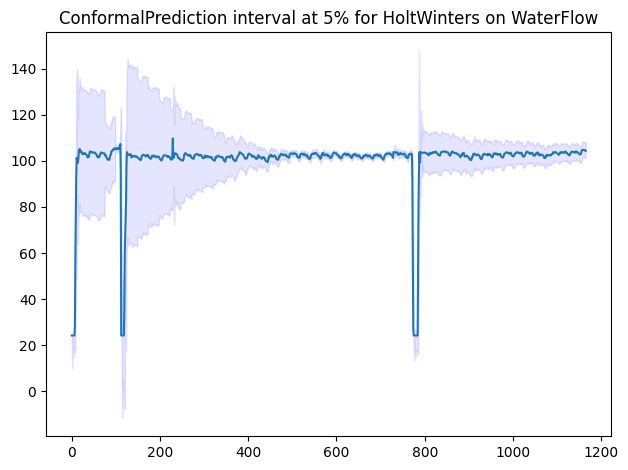

In [18]:
plot_interval(list_interval,list_y,plot_full)

This time, the performance of the model is taken into account in an iterative way. During periods of volatility in the model, the interval deviates greatly, while in periods of stability the method allows a higher level of confidence

# 3rd method : Adaptative Conformal Prediction

In [26]:
dataset = datasets.WaterFlow()

model = HoltWinters(
        alpha=0.8,
        beta=0.1,
        gamma=0.6,
        seasonality=2,
        multiplicative=True
        )

metric = metrics.MSE()

calib_period = 100
alpha=0.05
interval = conf.ACP.AdaptativeConformalPrediction(window_size=calib_period, gamma=0.0072, alpha=0.07)

# Run and get all the relevant lists
list_y, list_yh, list_ypred, list_metric, list_interval = run(model, dataset, metric, interval, horizon=1,verbose=False)

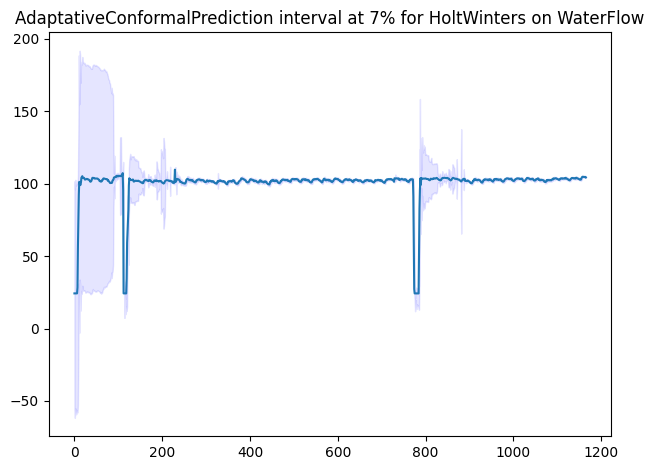

In [27]:
plot_interval(list_interval,list_y,plot_full)

In [21]:
tab_gamma = (0,
             0.000005,
             0.00005,
             0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,
             0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,
             0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09)


In [22]:
def plot_gamma_alpha(alpha,gamma):
        zoom = False
        dataset = datasets.WaterFlow()
        model = HoltWinters(
                alpha=0.8,
                beta=0.1,
                gamma=0.6,
                seasonality=2,
                multiplicative=True
        )
        metric = metrics.MSE()
        calib_period = 100
        interval = conf.ACP.AdaptativeConformalPrediction(window_size=calib_period, gamma=gamma, alpha=alpha)

        # Run and get all the relevant lists
        list_y, _, _, _, list_interval = run(model, dataset, metric, interval, horizon=1,verbose=False)

        if zoom:
                _ = plot_interval(list_interval,list_y,plot_zoom)
        else:

                _ = plot_interval(list_interval,list_y,plot_full)

In [23]:
widgets.interactive(plot_gamma_alpha,
                    alpha=widgets.FloatSlider(value=0.05,
                                              min=0.01,
                                              max=0.2,
                                              step=0.01,
                                              readout_format='.2f'),
                    gamma=widgets.FloatSlider(value=0.007,
                                              min=0.004,
                                              max=0.01,
                                              step=0.0001,
                                              readout_format='.6f')
)

interactive(children=(FloatSlider(value=0.05, description='alpha', max=0.2, min=0.01, step=0.01), FloatSlider(…

We see that a fine tuning of the 2 parameters alpha and gamma is necessary to obtain the desired performance. The tool above allows to visualize the dependency of the two variables on the construction of the interval. 